<a href="https://colab.research.google.com/github/smwalter96/map_tweets/blob/main/tweepy_geocode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopy
!pip install folium
!pip install geopandas

In [1]:
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener 
from tweepy import OAuthHandler
import csv
import pandas as pd
from geopy.geocoders import Nominatim
import folium
from geopy.extra.rate_limiter import RateLimiter

In [95]:
# Set tweepy keys and email
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""
email = ""

In [3]:
# Authorize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [91]:
# Set hashtags to search
tag = "#cruz"

In [92]:
# Search tweets with a given hashtag
# Return user location
df = pd.DataFrame()
for tweet in tweepy.Cursor(api.search,q=tag,count=100,
                           lang="en",
                           since="2021-01-11").items():    
    #print (tweet.user.location)
    df = df.append({'user_location': tweet.user.location, 'tweet_location': tweet.place,'text': tweet.text},ignore_index=True)
    

In [93]:
df.head()

,text,tweet_location,user_location
0,They hate you #Cruz and #Hawley https://t.co/t...,None,
1,RT @vankapro: 6000 #lawstudents with #lawyers\...,None,"Denver, CO"
2,RT @MicheleWMiller_: @highbrow_nobrow @jodotco...,None,
3,@thehill Best of luck! I’ve got a psychopathic...,None,
4,"""Sheldon Whitehouse Is Not Screwing Around Wit...",None,"British Columbia, Canada"


In [96]:
# Set geolocator fro geopy
geolocator = Nominatim(timeout=10, user_agent = email)

In [97]:
# Apply geocoder with ratelimit
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
 
# Run geocoder on dataframe and return latitude and longitude
df['location'] = df['user_location'].apply(geocode)
df['Lat'] = df['location'].apply(lambda x: x.latitude if x else None)
df['Lon'] = df['location'].apply(lambda x: x.longitude if x else None)
 
df.head()

,text,tweet_location,user_location,location,Lat,Lon
0,They hate you #Cruz and #Hawley https://t.co/t...,None,,None,NaN,NaN
1,RT @vankapro: 6000 #lawstudents with #lawyers\...,None,"Denver, CO","(Denver, Calle 16, Yopal, Casanare, Orinoquia,...",5.342848,-72.395985
2,RT @MicheleWMiller_: @highbrow_nobrow @jodotco...,None,,None,NaN,NaN
3,@thehill Best of luck! I’ve got a psychopathic...,None,,None,NaN,NaN
4,"""Sheldon Whitehouse Is Not Screwing Around Wit...",None,"British Columbia, Canada","(British Columbia, Canada, (55.001251, -125.00...",55.001251,-125.002441


In [98]:
# Set columns to map
df1 = df[['text', 'Lat', 'Lon']]

In [99]:
# Drop rows with no user location
df1.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


User Locations using Hashtag #cruz


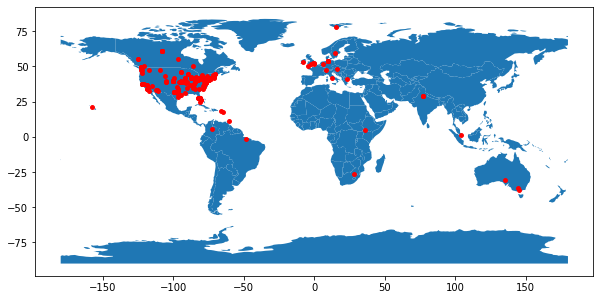

In [126]:
# Map user location
geometry = [Point(xy) for xy in zip(df1['Lon'], df1['Lat'])]
gdf = GeoDataFrame(df1, geometry=geometry)   

title_text = ('User Locations using Hashtag ' + tag)

print(title_text)
plt.show()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);


In [100]:
# Plot interactive user locations with tweet text in popups
map1 = folium.Map()
for index,row in df1.iterrows(): 
  popup = folium.Popup(row['text'],
                     max_width=500)
  folium.Marker(location=(row['Lat'],row['Lon']), popup=popup).add_to(map1)

display(map1)